# SN Different Roll Periods
* Functional version of the signal to noise for a different point.
* Exploring the S/N for different windows. This uses the functional version of the sn for single point

In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('seaborn-darkgrid')
import xarray as xr
import pandas as pd
from dask.diagnostics import ProgressBar

from importlib import reload
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from enum import Enum
from dask.diagnostics import ProgressBar
import sys, matplotlib, os
# Contains path information
sys.path.append('../')

import constants
sys.path.append(constants.MODULE_DIR)

import signal_to_noise as sn
# Custom xarray classes that addes different method.
import xarray_class_accessors as xca

# Custom plots for signal to noise functions.
import sn_plotting as sn_plot

In [2]:
constants.LONGRUNMIP_DIR

'/g/data/w40/ab2313/PhD/longrunmip'

In [3]:
# The directory where all of the longrun mip data used in this notebook is stored.
# ROOT_DIR = '/g/data/w40/ab2313/longrunmip/'
ROOT_DIR = os.path.join(constants.LONGRUNMIP_DIR,'regrid_retimestamped')
ROOT_DIR

'/g/data/w40/ab2313/PhD/longrunmip/regrid_retimestamped'

In [6]:
IMG_DIR = os.path.join(constants.IMAGE_SAVE_DIR, 'PhD/init')
IMG_DIR

'/home/563/ab2313/Documents/images/PhD/init'

In [7]:
fname = 'tas_ann_MPIESM11_abrupt4x_4459_g025'
model = 'MPIESM11'

# Loading Data
In this notebook everythning need to be run together to check the affect of having different roll period.s

In [8]:
path_control = os.path.join(ROOT_DIR, 'tas_mon_MPIESM12_control_1237_g025.nc')
path_control

'/g/data/w40/ab2313/PhD/longrunmip/regrid_retimestamped/tas_mon_MPIESM12_control_1237_g025.nc'

In [9]:
control_chunks = {'lat':48/2,'lon':96/2,'time':-1}

In [10]:
control = xr.open_dataset(path_control, use_cftime = True, chunks = control_chunks).tas
control 

<xarray.DataArray 'tas' (time: 1237, lat: 72, lon: 144)>
dask.array<open_dataset-5feed9d295121f924f8ead20ef99649btas, shape=(1237, 72, 144), dtype=float32, chunksize=(1237, 24, 48), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0000-12-31 00:00:00 ... 1236-12-31 00:00:00
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75

In [11]:
control = xr.open_dataset(path_control,use_cftime = True, chunks = control_chunks).tas
control

<xarray.DataArray 'tas' (time: 1237, lat: 72, lon: 144)>
dask.array<open_dataset-5feed9d295121f924f8ead20ef99649btas, shape=(1237, 72, 144), dtype=float32, chunksize=(1237, 24, 48), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0000-12-31 00:00:00 ... 1236-12-31 00:00:00
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75

In [12]:
path_abrupt4 = os.path.join(ROOT_DIR, 'tas_ann_MPIESM11_abrupt4x_4459_g025.nc')
path_abrupt4

'/g/data/w40/ab2313/PhD/longrunmip/regrid_retimestamped/tas_ann_MPIESM11_abrupt4x_4459_g025.nc'

In [13]:
abrupt = xr.open_dataset(path_abrupt4).tas
# abrupt = abrupt.rename({'year': 'time'})
abrupt

<xarray.DataArray 'tas' (time: 4459, lat: 72, lon: 144)>
[46230912 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * time     (time) object 0000-12-31 00:00:00 ... 4458-12-31 00:00:00
Attributes:
    long_name:  Near-Surface Air Temperature; usually on 2m
    units:      K
    code:       167
    table:      128

# Space Means

In [14]:
# The anomalies for the contorl.
control_anom = control.clima.anomalies(start = control.time.dt.year.values[0], 
                                          end = control.time.dt.year.values[-1])

# THe global mean of the anomalies.
control_anom_smean = control_anom.clima.space_mean()
control_anom_smean

<xarray.DataArray 'tas' (time: 1237)>
dask.array<truediv, shape=(1237,), dtype=float64, chunksize=(8,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0000-12-31 00:00:00 ... 1236-12-31 00:00:00

In [15]:
# Getting the temperature anomalies.
abrupt_anom = abrupt.clima.anomalies(start = control.time.dt.year.values[0], 
                                          end = control.time.dt.year.values[-1],
                            historical = control)

abrupt_anom_smean = abrupt_anom.clima.space_mean()
abrupt_anom_smean

Using historical dataset


<xarray.DataArray 'tas' (time: 4459)>
dask.array<truediv, shape=(4459,), dtype=float64, chunksize=(8,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0000-12-31 00:00:00 ... 4458-12-31 00:00:00

# Signal To Noise

In [16]:
reload(sn)
print(sn.global_mean_sn.__doc__)


    Calculates the signal to noise for an array da, based upon the control.
    
    A full guide on all the functions used here can be found at in 02_gmst_analysis.ipynb
    
    Note: 
    Returns 4 datasets: da_sn, da_sn_stable, da_sn_increasing, da_sn_decreasing
    
    
    But can be changed to return 9 datasets with return_all = True: 
                da_stable, da_increasing, da_decreasing, 
                da_sn, da_sn_stable, da_sn_increasing, da_sn_decreasing, 
                control_smean_lbound, control_smean_ubound
    da_sn_stable, da_sn_increasing, da_sn_decreasing, 
                control_smean_lbound, control_smean_ubound
    


In [17]:
(da_stable, da_increasing, da_decreasing, da_sn, da_sn_stable, da_sn_increasing, da_sn_decreasing, 
                control_smean_lbound, control_smean_ubound) =\
     sn.global_mean_sn(abrupt_anom_smean, control_anom_smean, window = 61, return_all=1)

Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -1.76 - U - 2.27
Caclulatiosn for experiment dataset:  - Signal - Noise - S/N
Getting stable and unstable time points
Function completed successfully!


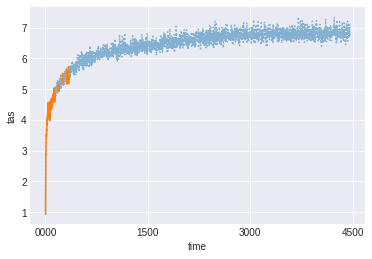

In [18]:
abrupt_anom_smean.plot(alpha = 0.5, linestyle=':')
da_increasing.plot()
da_decreasing.plot()

[<AxesSubplot:xlabel='Year', ylabel='$\\dfrac{Signal}{Noise}$'>,
 <AxesSubplot:ylabel='Tempearture\nAnomaly'>]

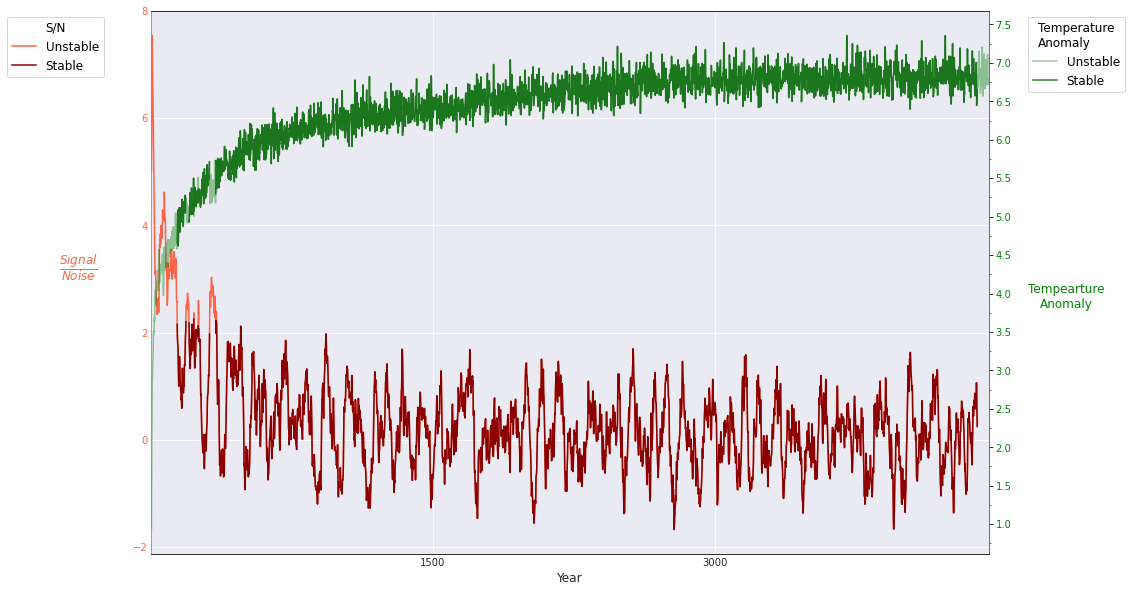

In [19]:
fig = plt.figure(figsize=  (15,10))
ax = fig.add_subplot(111)

sn_plot.temperature_vs_sn_plot(ax,  da_sn, abrupt_anom_smean,
                      temp_highlight = da_stable, 
                      sn_highlight = da_sn_stable)


# fig.savefig(f'{IMG_DIR}/{model}_global_sn_temp_anomaly.png', bbox_inches='tight', dpi=500)

# Multi-window

We now want to test the effect of multiple-windows.

In [20]:
reload(sn)
print(sn.sn_multi_window.__doc__)


    Calls the global_mean_sn function repeatedly for windows ranging betweent start_window
    and end_window with a step size of step_window.
    
    Parameters
    ----------
    
    da, control_da, start_window = 21, end_window = 221, step_window = 8
    
    
    Returns
    -------
    unstable_sn_multi_window_da , stable_sn_multi_window_da  Both these data sets contian dimension of time and window.
    


In [21]:
# Computing these values before hand to speed up calculations
abrupt_anom_smean = abrupt_anom_smean.compute()
control_anom_smean = control_anom_smean.compute()

In [143]:
print(sn.sn_multi_window.__doc__)


    Calls the global_mean_sn function repeatedly for windows ranging betweent start_window
    and end_window with a step size of step_window.
    
    Parameters
    ----------
    
    da, control_da, start_window = 21, end_window = 221, step_window = 8
    
    
    Returns
    -------
    unstable_sn_multi_window_da , stable_sn_multi_window_da  Both these data sets contian dimension of time and window.
    


In [156]:
unstable_sn_multi_window_da , stable_sn_multi_window_da =\
                sn.sn_multi_window(abrupt_anom_smean,control_anom_smean, end_window=500, step_window=2)

Starting window loop from 21 to 500 with step size of 2
21, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -3.11 - U - 3.34
Caclulatiosn for experiment dataset:  - Signal - Noise - S/N
Getting stable and unstable time points
Function completed successfully!
23, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -3.01 - U - 3.22
Caclulatiosn for experiment dataset:  - Signal - Noise - S/N
Getting stable and unstable time points
Function completed successfully!
25, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -3.08 - U - 3.33
Caclulatiosn for experiment dataset:  - Signal - Noise - S/N
Getting stable and unstable time points
Function completed successfully!
27, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -3.13 - U - 3.25
Caclulatiosn for experiment dataset:  - Signal - Noise - S/N
Getting stable and unstable time points
Function completed successfully!
29, Caclulations for control dataset:  -

93, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -1.51 - U - 1.73
Caclulatiosn for experiment dataset:  - Signal - Noise - S/N
Getting stable and unstable time points
Function completed successfully!
95, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -1.44 - U - 1.72
Caclulatiosn for experiment dataset:  - Signal - Noise - S/N
Getting stable and unstable time points
Function completed successfully!
97, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -1.41 - U - 1.74
Caclulatiosn for experiment dataset:  - Signal - Noise - S/N
Getting stable and unstable time points
Function completed successfully!
99, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -1.47 - U - 1.77
Caclulatiosn for experiment dataset:  - Signal - Noise - S/N
Getting stable and unstable time points
Function completed successfully!
101, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -1.50 - U - 1.80
Cac

165, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -1.59 - U - 1.41
Caclulatiosn for experiment dataset:  - Signal - Noise - S/N
Getting stable and unstable time points
Function completed successfully!
167, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -1.61 - U - 1.39
Caclulatiosn for experiment dataset:  - Signal - Noise - S/N
Getting stable and unstable time points
Function completed successfully!
169, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -1.68 - U - 1.45
Caclulatiosn for experiment dataset:  - Signal - Noise - S/N
Getting stable and unstable time points
Function completed successfully!
171, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -1.67 - U - 1.44
Caclulatiosn for experiment dataset:  - Signal - Noise - S/N
Getting stable and unstable time points
Function completed successfully!
173, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -1.66 - U - 1.49

237, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -1.12 - U - 0.90
Caclulatiosn for experiment dataset:  - Signal - Noise - S/N
Getting stable and unstable time points
Function completed successfully!
239, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -1.07 - U - 0.89
Caclulatiosn for experiment dataset:  - Signal - Noise - S/N
Getting stable and unstable time points
Function completed successfully!
241, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -1.02 - U - 0.86
Caclulatiosn for experiment dataset:  - Signal - Noise - S/N
Getting stable and unstable time points
Function completed successfully!
243, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -0.98 - U - 0.85
Caclulatiosn for experiment dataset:  - Signal - Noise - S/N
Getting stable and unstable time points
Function completed successfully!
245, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -0.99 - U - 0.84

309, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -0.67 - U - 0.44
Caclulatiosn for experiment dataset:  - Signal - Noise - S/N
Getting stable and unstable time points
Function completed successfully!
311, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -0.65 - U - 0.44
Caclulatiosn for experiment dataset:  - Signal - Noise - S/N
Getting stable and unstable time points
Function completed successfully!
313, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -0.65 - U - 0.45
Caclulatiosn for experiment dataset:  - Signal - Noise - S/N
Getting stable and unstable time points
Function completed successfully!
315, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -0.64 - U - 0.43
Caclulatiosn for experiment dataset:  - Signal - Noise - S/N
Getting stable and unstable time points
Function completed successfully!
317, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -0.61 - U - 0.42

381, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -0.48 - U - 0.41
Caclulatiosn for experiment dataset:  - Signal - Noise - S/N
Getting stable and unstable time points
Function completed successfully!
383, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -0.48 - U - 0.43
Caclulatiosn for experiment dataset:  - Signal - Noise - S/N
Getting stable and unstable time points
Function completed successfully!
385, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -0.48 - U - 0.41
Caclulatiosn for experiment dataset:  - Signal - Noise - S/N
Getting stable and unstable time points
Function completed successfully!
387, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -0.46 - U - 0.40
Caclulatiosn for experiment dataset:  - Signal - Noise - S/N
Getting stable and unstable time points
Function completed successfully!
389, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -0.45 - U - 0.40

453, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -0.68 - U - 0.41
Caclulatiosn for experiment dataset:  - Signal - Noise - S/N
Getting stable and unstable time points
Function completed successfully!
455, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -0.67 - U - 0.43
Caclulatiosn for experiment dataset:  - Signal - Noise - S/N
Getting stable and unstable time points
Function completed successfully!
457, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -0.66 - U - 0.42
Caclulatiosn for experiment dataset:  - Signal - Noise - S/N
Getting stable and unstable time points
Function completed successfully!
459, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -0.67 - U - 0.43
Caclulatiosn for experiment dataset:  - Signal - Noise - S/N
Getting stable and unstable time points
Function completed successfully!
461, Caclulations for control dataset:  - Signal - Noise - S/N - Bounds - L -0.65 - U - 0.45

In [145]:
unstable_sn_multi_window_da

<xarray.DataArray 'SN' (window: 120, time: 4439)>
array([[ 4.00161037,  4.54167087,  5.29744358, ...,         nan,
                nan,         nan],
       [ 4.12069964,  4.67492685,  5.5101013 , ...,         nan,
                nan,         nan],
       [ 4.26888645,  4.97158403,  5.98006438, ...,         nan,
                nan,         nan],
       ...,
       [11.20976909, 12.98361067, 14.32199514, ...,         nan,
                nan,         nan],
       [11.17999415, 12.96190548, 14.29464836, ...,         nan,
                nan,         nan],
       [11.23026858, 13.00997756, 14.33744478, ...,         nan,
                nan,         nan]])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 ... 4432 4433 4434 4435 4436 4437 4438
  * window   (window) int64 21 25 29 33 37 41 45 ... 473 477 481 485 489 493 497

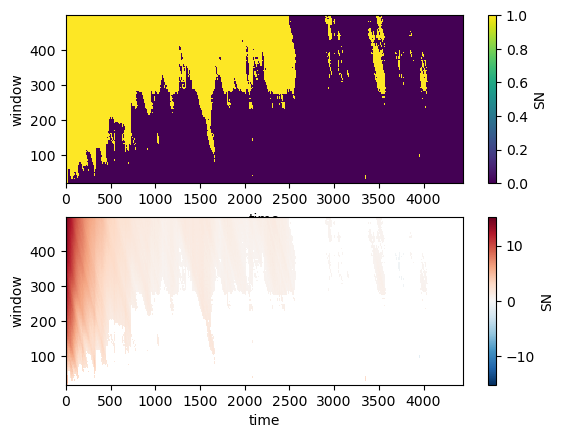

In [146]:
fig, (ax1, ax2) = plt.subplots(2,1)
stable_sn_multi_window_da.plot(ax=ax1)
unstable_sn_multi_window_da.plot(ax=ax2)

{'height': 15, 'width': 7, 'hspace': 0.3, 'vmin': -8, 'vmax': 8, 'step': 1, 'cmap': 'RdBu_r', 'line_color': 'limegreen', 'line_alpha': 0.5, 'cbar_label': 'S/N', 'title': 'MPIESM11', 'label_size': 12}


(0.0, 4500.0)

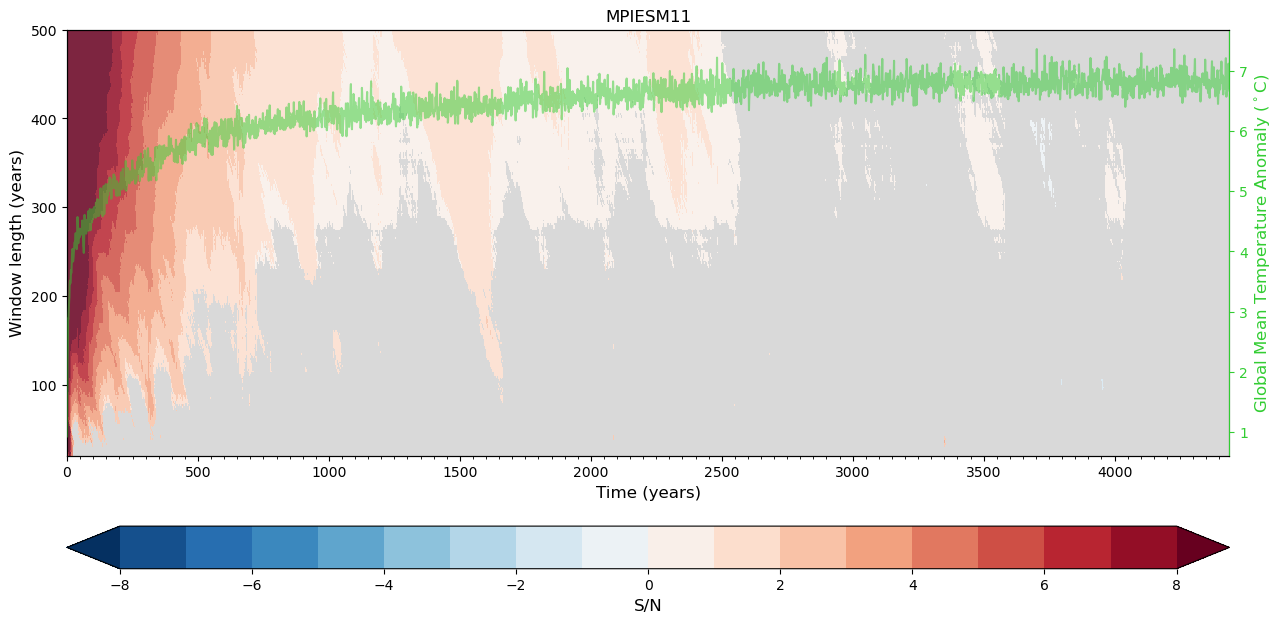

In [157]:
sn_plot.sn_multi_window_in_time(unstable_sn_multi_window_da, 
                            stable_sn_multi_window_da,
                            abrupt_anom_smean, title=model, step=1);
ax.set_xlim([0,4500])
# fig.savefig(f'{IMG_DIR}/{model}_SN_multi_window_long_small_step.png', dpi=400, bbox_inches='tight')